In [29]:
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.set_option('display.max_colwidth', 300)

# Read data
df = pd.read_pickle('Data\MovieSummaries\plots_genres_reduced_to_60.pkl')
df_train = pd.read_pickle('Data/MovieSummaries/train_plots_genres_reduced_to_60.pkl')
df_test = pd.read_pickle('Data/MovieSummaries/test_plots_genres_reduced_to_60.pkl')

# Preprocessing functions
def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

def remove_stopwords(text):
    no_stop = []
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

def freq_plot(text):
    
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
#Dataset overview
df.reset_index(inplace=True)
df.head()

df_train.reset_index(inplace=True)
df_train.head()

df_test.reset_index(inplace=True)
df_test.head()

,index,id,text,title,genre
0,21689,13649283,preeti virat is a young vivacious and naive woman she comes forward as a witness to heinous assault carried by bhavani choudhry and his men on a person who owes them money her testimony angers the choudhry family and as a result choudhrys brother rapes her subsequently she becomes a disgrace eve...,Hamara Dil Aapke Paas Hai,"[musical, drama, bollywood, war]"
1,12073,5561269,expand section buster keaton is a bank teller who becomes involved in a holdup counterfeiters and a theatrical troupe posing as spooks in a haunted house the film ends with a famous sequence of keaton ascending to heaven and then descending to hades,The Haunted House,"[short, silent, comedy, blackandwhite]"
2,9570,3954917,a couple proceeds with the purchase and moves in george appears not to be strong of faith but kathy is at least a nominal catholic the couple turns to father delaney to bless the home father delaney encounters troubles in trying to bless the home including a room full of flies out of season viol...,The Amityville Horror,"[cult, drama, adaptation, horror, supernatural]"
3,35643,28964840,johnay and nimmy are students of school who fell in love with each other but nimmys father alexander discovers his daughters affair with jonhy and kills him by gun until johnnys father zachariah aveages his sons death,Inakkilly,[drama]
4,11305,5103474,the film is a cartoon cat version of thomas pynchons novel the crying of lot httpukimdbcomtitleusercomments it begins in meguro city tokyo cat earth a world of corporations and commercialism where a giant mechanical colonel sanders wanders the streets with an axe embedded in its head loudly adve...,Tamala 2010: A Punk Cat in Space,"[science fiction, japanese, animation]"


In [31]:
#clean text
df["text"] = df["text"].apply(lambda x : clean_text(x))
df_train["text"] = df_train["text"].apply(lambda x : clean_text(x))
df_test["text"] = df_test["text"].apply(lambda x : clean_text(x))

# Get stopwords
#if stopwords not downloaded
#
stopwords = set(stopwords.words("english"))
df["text"] = df["text"].apply(lambda x : remove_stopwords(x))
df_train["text"] = df_train["text"].apply(lambda x : remove_stopwords(x))
df_test["text"] = df_test["text"].apply(lambda x : remove_stopwords(x))

# Binarize genres
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_bina = MultiLabelBinarizer()
multilabel_bina.fit(df["genre"])

ytrain = multilabel_bina.transform(df_train["genre"])
yval = multilabel_bina.transform(df_test["genre"])
xtrain = df_train["text"]
xval = df_test["text"]

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_df= 0.8, max_features= 10000)
#xtrain, xval, ytrain, yval = train_test_split(df["text"], y, test_size = 0.2, random_state= 9)
xtrain_tfidf = tfidf_vect.fit_transform(xtrain)
xval_tfidf = tfidf_vect.transform(xval)

In [32]:
#make list aff all genre
genre_list = []
for i in range(len(df["genre"])):
    genre_list.append(df["genre"].iloc[i][0])

#unique genre
unique_genre = list(set(genre_list))
len(unique_genre)

57

In [33]:
# Documents Example with 5 Plots
documents = df["text"][0:5].reset_index(drop=True)

# Term Frequency-Inverse Document Frequency vectorizer
Tfid_vect = TfidfVectorizer()

# Transform the documents using the vectorizer
documents_vect = Tfid_vect.fit_transform(documents)

# Convert the transformed for better visability. Normally sparse matrix
#df = pd.DataFrame(documents_vect.toarray(), columns=Tfid_vect.get_feature_names_out())

#df

# Multi label logistic Regression

In [34]:

# Logistic Regression
logistic_mod = LogisticRegression()

# Separate binary classifier for each class label for multi-label classification
onevsall = OneVsRestClassifier(logistic_mod) 

# Train model
onevsall.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)



c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

              precision    recall  f1-score   support

           0       0.65      0.26      0.37      1209
           1       0.60      0.12      0.20       712
           2       0.00      0.00      0.00       231
           3       0.73      0.13      0.23       729
           4       0.77      0.32      0.45       502
           5       0.00      0.00      0.00        70
           6       0.00      0.00      0.00       138
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00        59
           9       0.86      0.11      0.19       757
          10       0.00      0.00      0.00        71
          11       0.68      0.07      0.12       222
          12       1.00      0.01      0.02       127
          13       0.00      0.00      0.00       152
          14       0.81      0.23      0.36       183
          15       0.73      0.46      0.56      2549
          16       0.00      0.00      0.00       262
          17       1.00    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results/Metrics/classification_report_reduced_to_60_log_reg.csv', index=True, sep=';')

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df_test['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df_test['genre'][k], "\n")

Movie:  Spirit of the Forest 
Predicted genre:  [('comedy',)]
Actual genre:  ['family', 'childrensfamily', 'comedy', 'animation'] 

Movie:  Punam 
Predicted genre:  [('drama',)]
Actual genre:  ['short'] 

Movie:  Time Out for Rhythm 
Predicted genre:  [('comedy', 'romance')]
Actual genre:  ['musical', 'comedy', 'slapstick'] 

Movie:  Two Tickets to Paradise 
Predicted genre:  [('comedy',)]
Actual genre:  ['comedydrama', 'indie', 'comedy'] 

Movie:  Valmont 
Predicted genre:  [('drama',)]
Actual genre:  ['indie', 'war', 'drama', 'period piece', 'adaptation', 'romance'] 



In [37]:
#Apply it to all Film
f = pd.DataFrame(xval)
f['generated_genre'] = pd.DataFrame(xval)['text'].apply(new_val)
f= f.merge(df_test, left_index=True, how='left', right_index=True).reset_index(drop=True)
f.head(10)

,text_x,generated_genre,index,id,text_y,title,genre
0,preeti virat young vivacious naive woman comes forward witness heinous assault carried bhavani choudhry men person owes money testimony angers choudhry family result choudhrys brother rapes subsequently becomes disgrace even family disowned family secluded society leaves house finds shelter cour...,"[(drama,)]",21689,13649283,preeti virat young vivacious naive woman comes forward witness heinous assault carried bhavani choudhry men person owes money testimony angers choudhry family result choudhrys brother rapes subsequently becomes disgrace even family disowned family secluded society leaves house finds shelter cour...,Hamara Dil Aapke Paas Hai,"[musical, drama, bollywood, war]"
1,expand section buster keaton bank teller becomes involved holdup counterfeiters theatrical troupe posing spooks haunted house film ends famous sequence keaton ascending heaven descending hades,"[(comedy,)]",12073,5561269,expand section buster keaton bank teller becomes involved holdup counterfeiters theatrical troupe posing spooks haunted house film ends famous sequence keaton ascending heaven descending hades,The Haunted House,"[short, silent, comedy, blackandwhite]"
2,couple proceeds purchase moves george appears strong faith kathy least nominal catholic couple turns father delaney bless home father delaney encounters troubles trying bless home including room full flies season violent stomach sickness later blisters palm trying make even phone contact kathy h...,"[(horror,)]",9570,3954917,couple proceeds purchase moves george appears strong faith kathy least nominal catholic couple turns father delaney bless home father delaney encounters troubles trying bless home including room full flies season violent stomach sickness later blisters palm trying make even phone contact kathy h...,The Amityville Horror,"[cult, drama, adaptation, horror, supernatural]"
3,johnay nimmy students school fell love nimmys father alexander discovers daughters affair jonhy kills gun johnnys father zachariah aveages sons death,"[(drama,)]",35643,28964840,johnay nimmy students school fell love nimmys father alexander discovers daughters affair jonhy kills gun johnnys father zachariah aveages sons death,Inakkilly,[drama]
4,film cartoon cat version thomas pynchons novel crying lot httpukimdbcomtitleusercomments begins meguro city tokyo cat earth world corporations commercialism giant mechanical colonel sanders wanders streets axe embedded head loudly advertising restaurant tamala bored city leaves human mother boar...,[()],11305,5103474,film cartoon cat version thomas pynchons novel crying lot httpukimdbcomtitleusercomments begins meguro city tokyo cat earth world corporations commercialism giant mechanical colonel sanders wanders streets axe embedded head loudly advertising restaurant tamala bored city leaves human mother boar...,Tamala 2010: A Punk Cat in Space,"[science fiction, japanese, animation]"
5,ten years birth dane meghann meggie oneill forced run drogheda basically since brothers went fight world war ii make matters worse two year drought struck area one day meggies estranged husband luke arrived drogheda begs forgiveness meggie lonely need man run ranch father children reluctantly ta...,[()],10410,4488493,ten years birth dane meghann meggie oneill forced run drogheda basically since brothers went fight world war ii make matters worse two year drought struck area one day meggies estranged husband luke arrived drogheda begs forgiveness meggie lonely need man run ranch father children reluctantly ta...,The Thorn Birds: The Missing Years,[drama]
6,halley marie martin yearold high school student disillusioned love seeing many dysfunctional relationships around parents divorced father len martin radio talk show host new young girlfriend entire family despises mainly shes reason divorce mother lydia always alone sister ashley overwhelmed upc...,"[(comedy, drama, romance)]",4015,1380903,halley marie martin yearold hi

Naive Bayes

In [38]:
# do with naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(GaussianNB())

# Train the classifier on the training set
classifier.fit(xtrain_tfidf.toarray(), ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf.toarray())
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec.toarray())
    return multilabel_bina.inverse_transform(x_pred)

              precision    recall  f1-score   support

           0       0.27      0.67      0.39      1209
           1       0.16      0.64      0.25       712
           2       0.03      0.36      0.06       231
           3       0.16      0.64      0.26       729
           4       0.21      0.67      0.32       502
           5       0.01      0.04      0.01        70
           6       0.01      0.09      0.02       138
           7       0.02      0.18      0.04       120
           8       0.01      0.10      0.02        59
           9       0.15      0.75      0.25       757
          10       0.01      0.04      0.02        71
          11       0.09      0.36      0.14       222
          12       0.03      0.11      0.04       127
          13       0.04      0.20      0.07       152
          14       0.05      0.25      0.09       183
          15       0.46      0.70      0.55      2549
          16       0.05      0.33      0.08       262
          17       0.03    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df_test['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df_test['genre'][k], "\n")

Movie:  Alive and Ticking 
Predicted genre:  [('action', 'actionadventure', 'adventure', 'biographical', 'biography', 'biopic feature', 'comedydrama', 'crime', 'documentary', 'drama', 'ensemble', 'fantasy', 'indie', 'lgbt', 'music', 'psychological thriller', 'romance', 'satire', 'science fiction', 'suspense', 'thriller')]
Actual genre:  ['family', 'drama', 'comedy'] 

Movie:  Lady by Choice 
Predicted genre:  [('adaptation', 'blackandwhite', 'comedy', 'crime', 'drama', 'musical', 'romance')]
Actual genre:  ['comedydrama'] 

Movie:  Shaolin Soccer 
Predicted genre:  [('action', 'actionadventure', 'adventure', 'chinese', 'fantasy', 'war')]
Actual genre:  ['actionadventure', 'war', 'sports', 'martial arts', 'comedy', 'action', 'chinese'] 

Movie:  Orr Eravuu 
Predicted genre:  [('crime', 'mystery', 'thriller')]
Actual genre:  ['thriller', 'mystery', 'horror'] 

Movie:  Carnal Madness 
Predicted genre:  [('comedy', 'crime', 'documentary', 'indie', 'japanese', 'mystery', 'parody', 'teen')]


In [40]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results\Metrics\classification_report_reduced_60_NB.csv', index=True, sep=';')

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

In [ ]:
#do state vector machine
import sklearn.svm as svm
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))

# Train the classifier on the training set
classifier.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)

In [ ]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

## Multilabel classification confusion matrix with MLCM Paper function

In [41]:
#clean lists
for i in range(len(f["generated_genre"])):
    f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]

#sort lists in genre alphabetically
f["genre"] = f["genre"].apply(lambda x: sorted(x))


###prepare for library

# Create a set 
unique_genre = set()
for genres in f["genre"]:
    unique_genre.update(genres)
unique_genre = list(unique_genre)


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6440\2283300800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]


### MLCM Library with minor changes in code

In [42]:
#Numpy Version problems solved
from mlcm_changed import mlcm

c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:208: RuntimeWarning: invalid value encountered in divide
  recall = tp/(tp+fn)



       class#     precision        recall      f1-score        weight

            0          0.17          0.09          0.12          8731
            1          0.07          0.10          0.08          4584
            2          0.01          0.05          0.02          1556
            3          0.07          0.09          0.08          4960
            4          0.09          0.10          0.10          3259
            5          0.00          0.01          0.00          491
            6          0.01          0.01          0.01          957
            7          0.01          0.02          0.01          956
            8          0.00          0.02          0.01          386
            9          0.07          0.08          0.07          7100
            10          0.01          0.00          0.01          605
            11          0.05          0.07          0.06          1151
            12          0.01          0.02          0.01          827
            13       

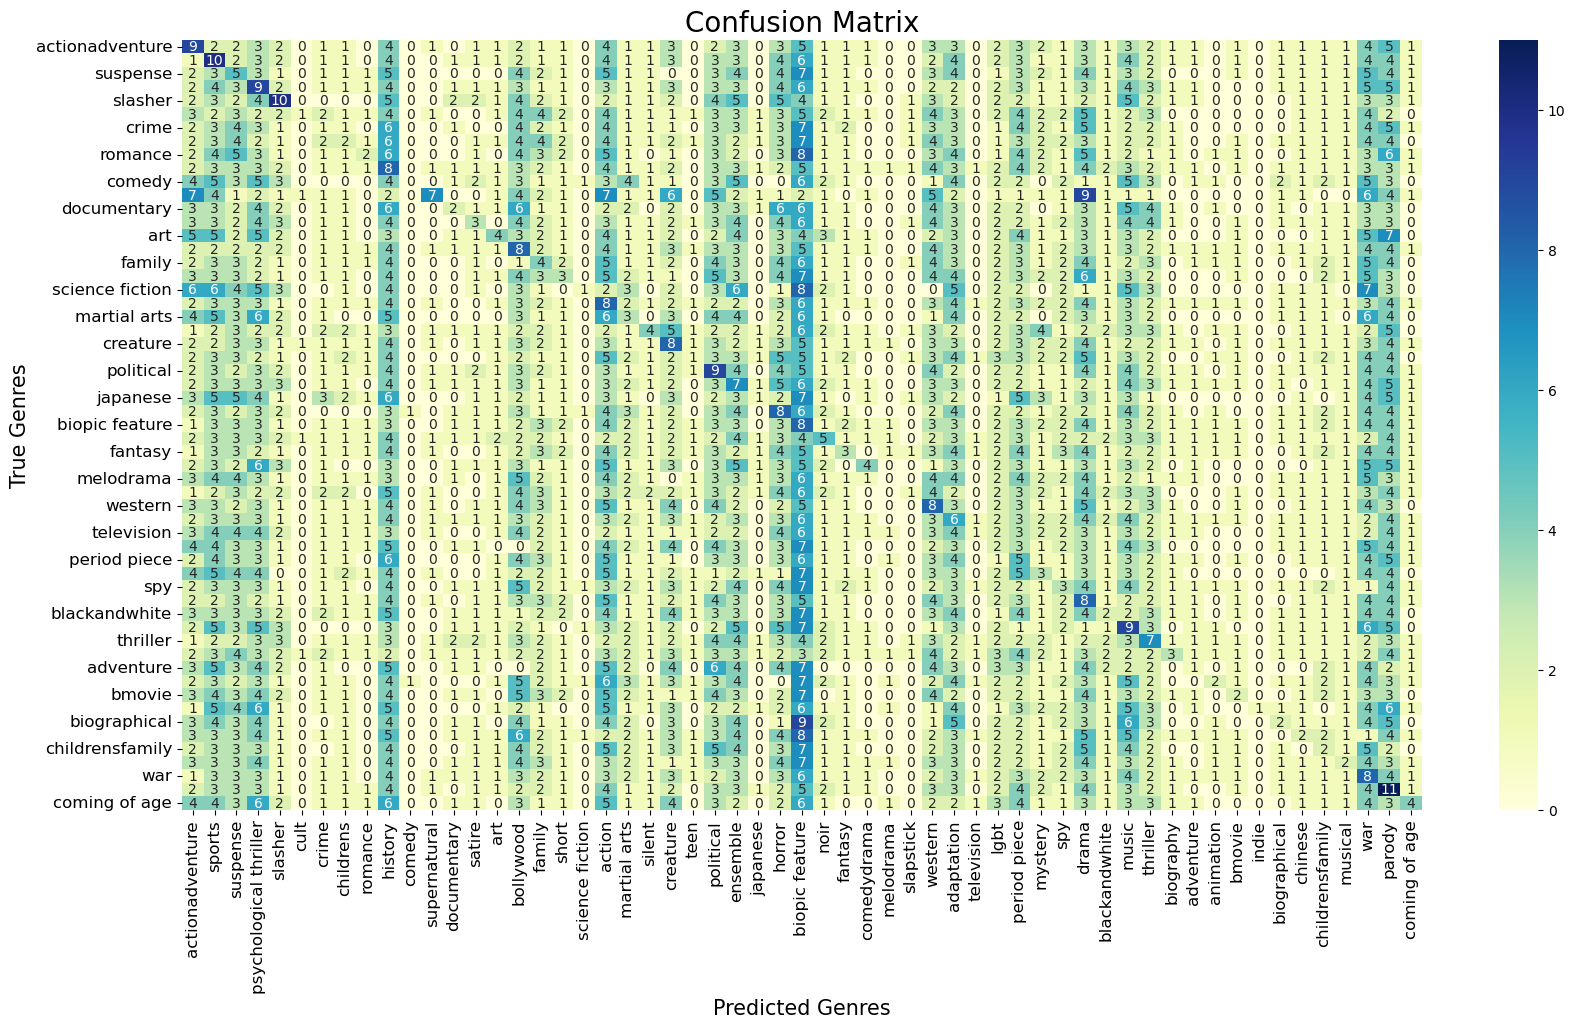

In [43]:
conf_mat,normal_conf_mat = mlcm.cm(yval,y_pred,False)

one_vs_rest = mlcm.stats(conf_mat,False)

colnames = unique_genre + ['NPL']
rownames = unique_genre + ['NTL']


#make dataframe from confusion matrix
df_confusion = pd.DataFrame(normal_conf_mat, columns=colnames, index=rownames)
df_confusion.drop('NTL', inplace=True)
df_confusion.drop('NPL', axis=1, inplace=True)

#plot df_confusion
plt.figure(figsize = (20,10))
sns.heatmap(df_confusion, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Genres', fontsize=15)
plt.ylabel('True Genres', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

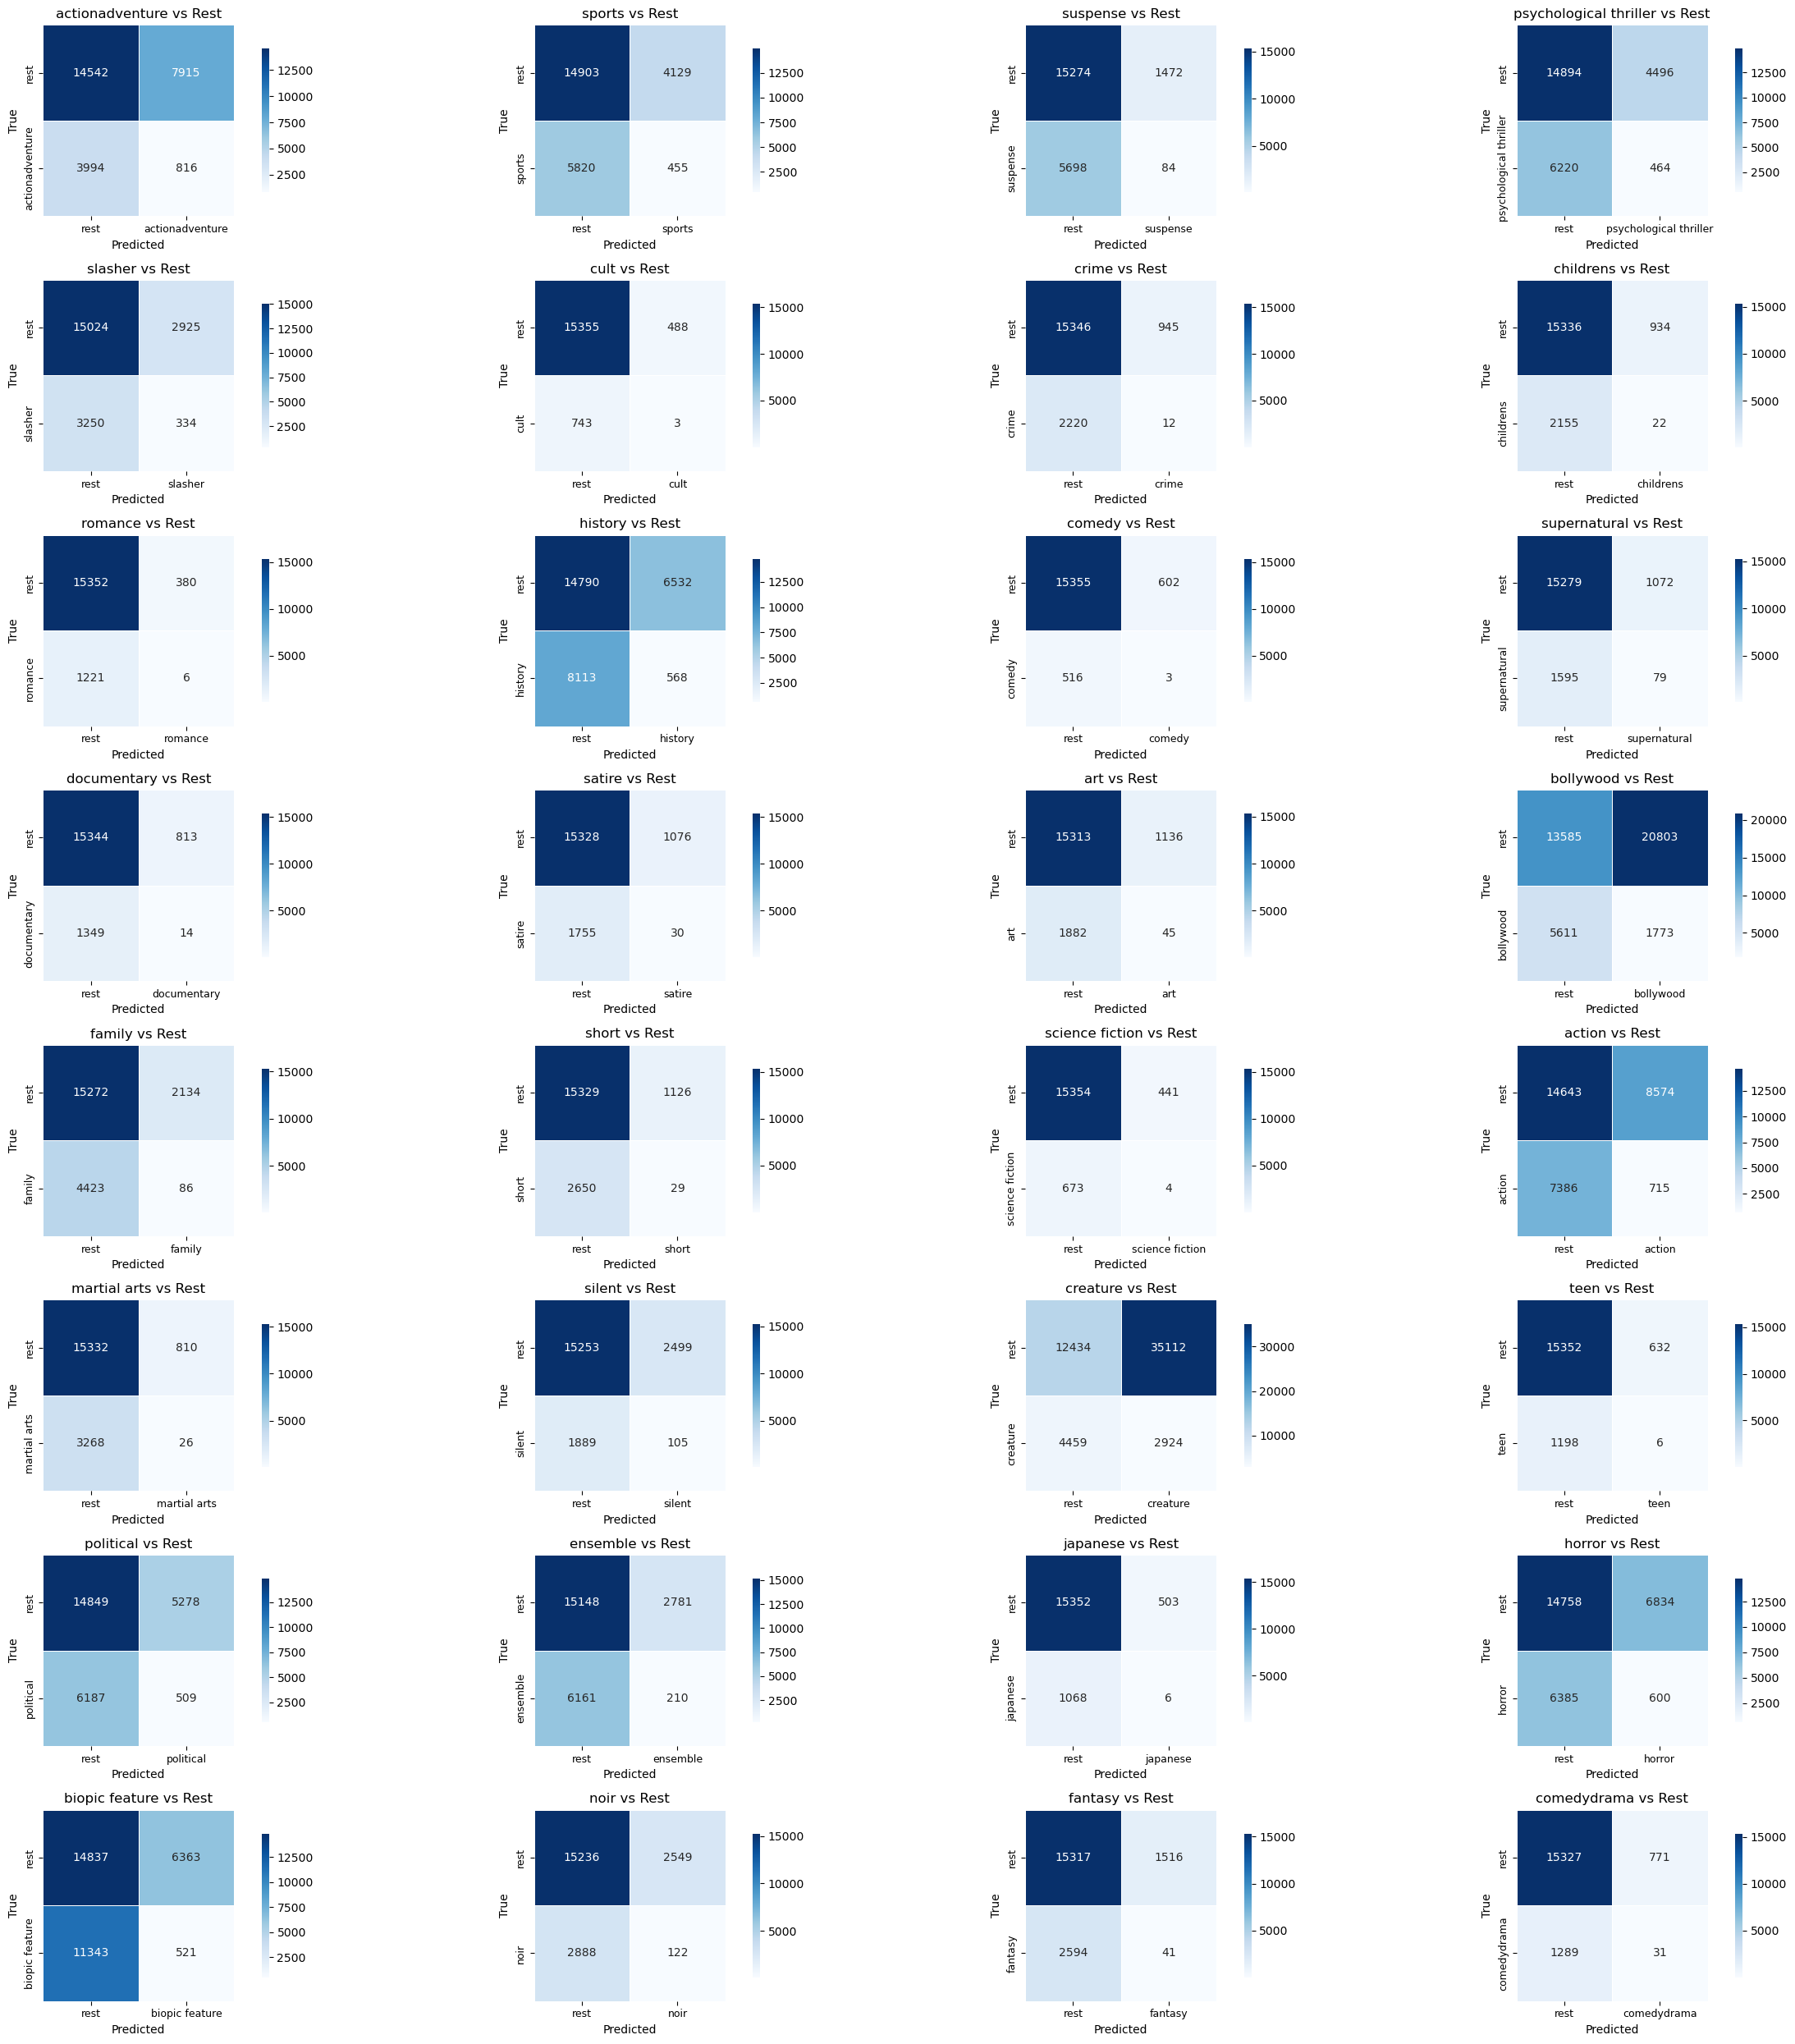

In [44]:

plt.figure(figsize=(25, 25))


n=32
#  first n
for i in range(n):  
    #column names
    colnames = ['rest', unique_genre[i]]
    
    #DataFrame
    df1 = pd.DataFrame(one_vs_rest[i], columns=colnames, index=['rest' , unique_genre[i]]).transpose()

    ax = plt.subplot(int(n/4), 4, i + 1)
    
    #heatmap
    sns.heatmap(df1, annot=True, fmt="d", cmap="Blues", square=True, linewidths=.5, cbar_kws={"shrink": .75})

    # Titles and labels
    ax.set_title(f'{unique_genre[i]} vs Rest', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()
